In [62]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from arch import arch_model
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_predict

In [12]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(20, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [15]:
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")

df = robberies_in_boston.Count

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


/home/stan/deeplearn/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


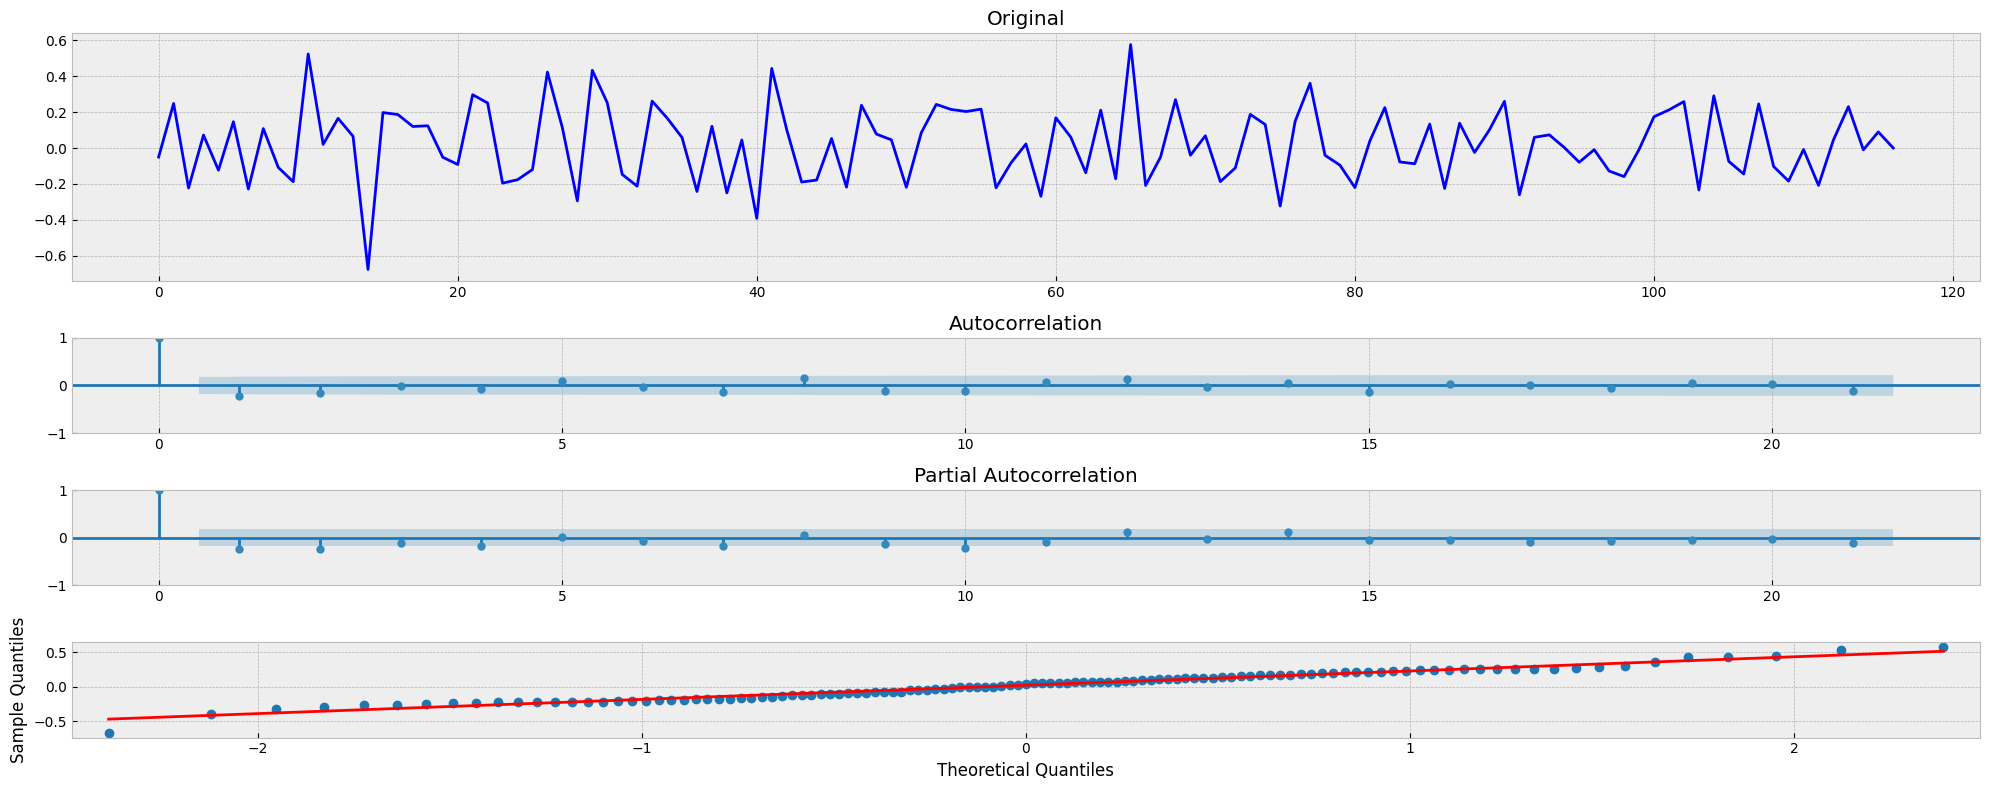

In [17]:
#Box-cox+дифференцирование
df_st = np.diff(boxcox(df, 0), 1)
tsplot(df_st)

In [48]:
train, val = df_st[:100], df_st[100:]

  0%|          | 0/5 [00:00<?, ?it/s]

aic: -35.36487 | order: (1, 0, 1)
Results of Dickey-Fuller Test:
Test Statistic                -1.019120e+01
p-value                        6.315643e-18
#Lags Used                     0.000000e+00
Number of Observations Used    9.900000e+01
Critical Value (1%)           -3.498198e+00
Critical Value (5%)           -2.891208e+00
Critical Value (10%)          -2.582596e+00
dtype: float64


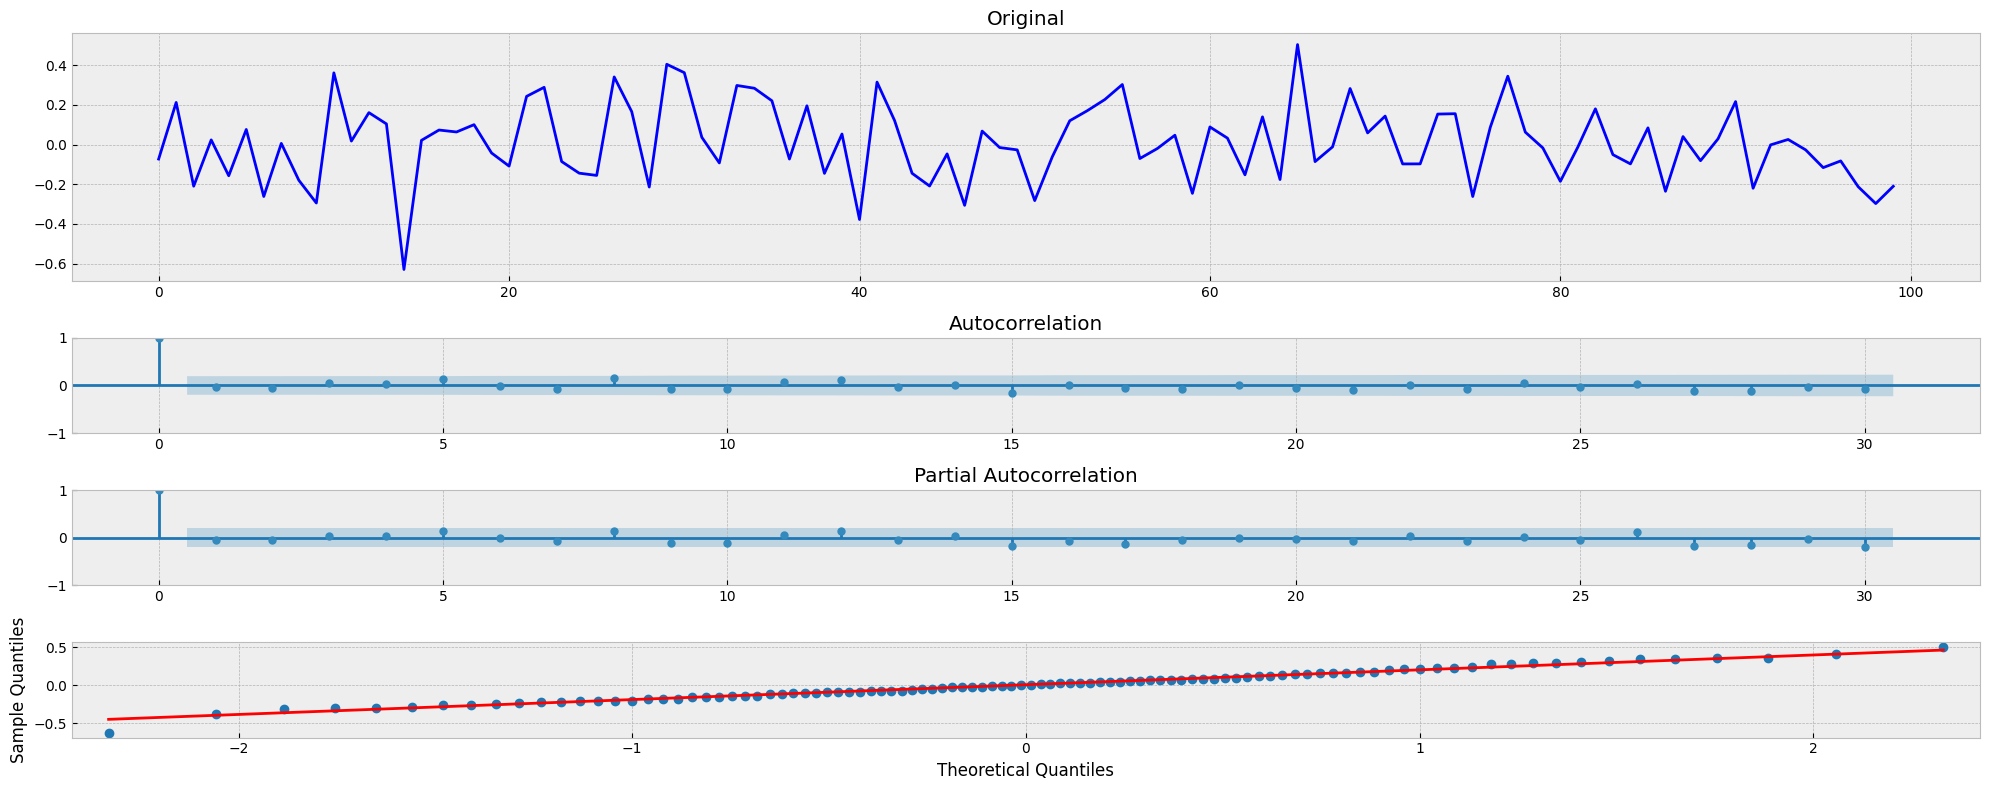

In [73]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in tqdm(range(5)):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(train, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

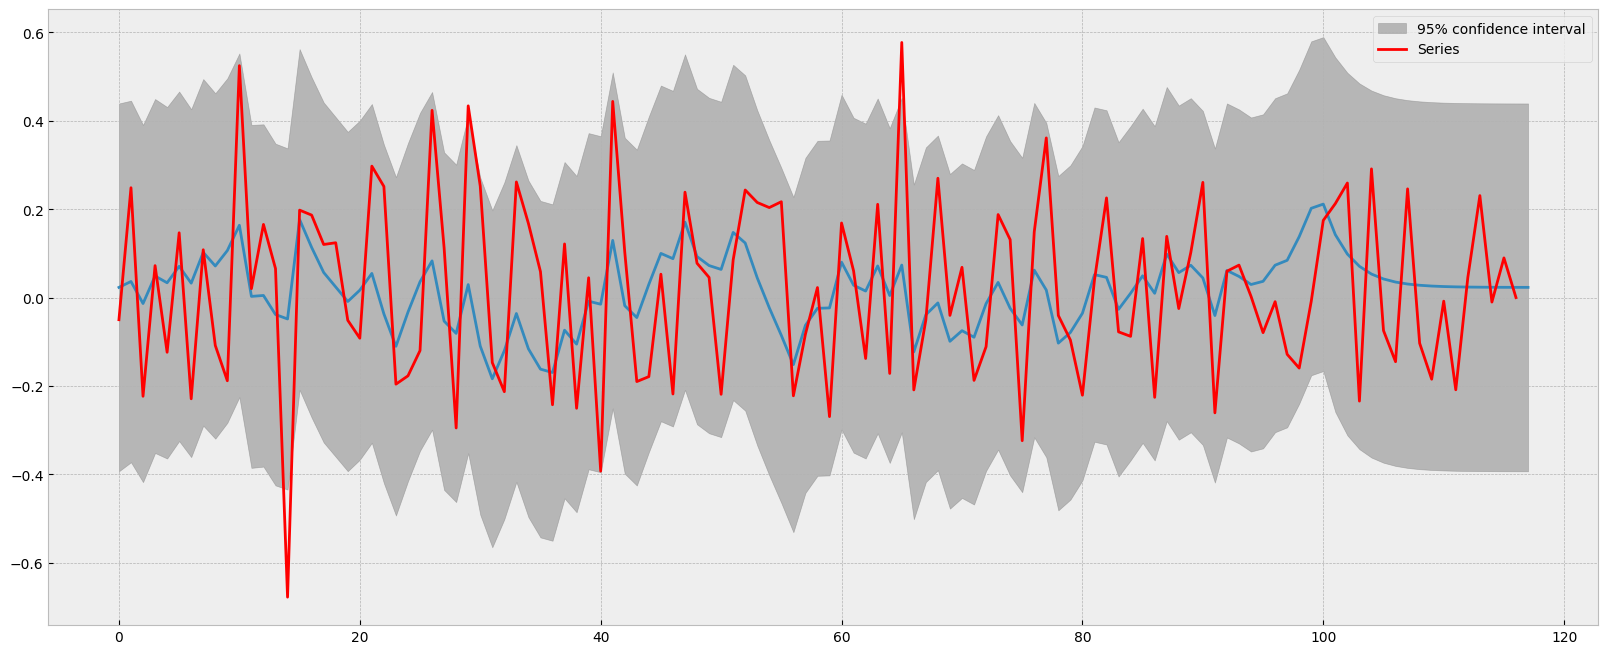

In [75]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    plot_predict(best_mdl,0,len(df_st), ax=ax)
    plt.plot(df_st, color='red', label='Series')
    plt.legend()
    plt.show()

In [ ]:
В доверительный интервал попали